In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
import os

## Remove Dodgy Images

In [4]:
import cv2
import imghdr


In [5]:
data_dir = '/content/drive/MyDrive/ImageClassification/data'
image_exts = ['jpeg','jpg','bmp','png']

In [6]:
# We'll loop through each folder, each image and check if its extension falls
# within the mentioned list. If not we'll remove them
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image{}'.format(image_path))

In [7]:
img = cv2.imread(os.path.join(data_dir,'happy','1-2.jpg'))

In [8]:
#plt.imshow(img) # gives image in bgr color format
# plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
# plt.show()

## **Load Data**

In [9]:
import numpy as np
import matplotlib.pyplot as plt


**data = tf.keras.utils.image_dataset_from_directory() ??**
**Below given Properties can be changed**

*labels='inferred', label_mode='int', class_names=None,
color_mode='rgb', batch_size=32, image_size=(2 items) (256, 256),
shuffle=True, seed=None, validation_split=None, subset=None,
interpolation='bilinear', follow_links=False,
crop_to_aspect_ratio=False, **kwargs)*

batch_size, image_size, etc all can be changed accordingly

In [10]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/ImageClassification/data')

Found 181 files belonging to 2 classes.


In [11]:
#to convert data into numpy iterator to access them batch by batch
data_iterator = data.as_numpy_iterator()

In [12]:
# To get another batch from iterator
batch = data_iterator.next() # batch has 2 elements --> index 0 = images, 1 = labels

In [13]:
batch[0].shape # 32 images data

(32, 256, 256, 3)

In [14]:
batch[1].shape # Corresponding labels

(32,)

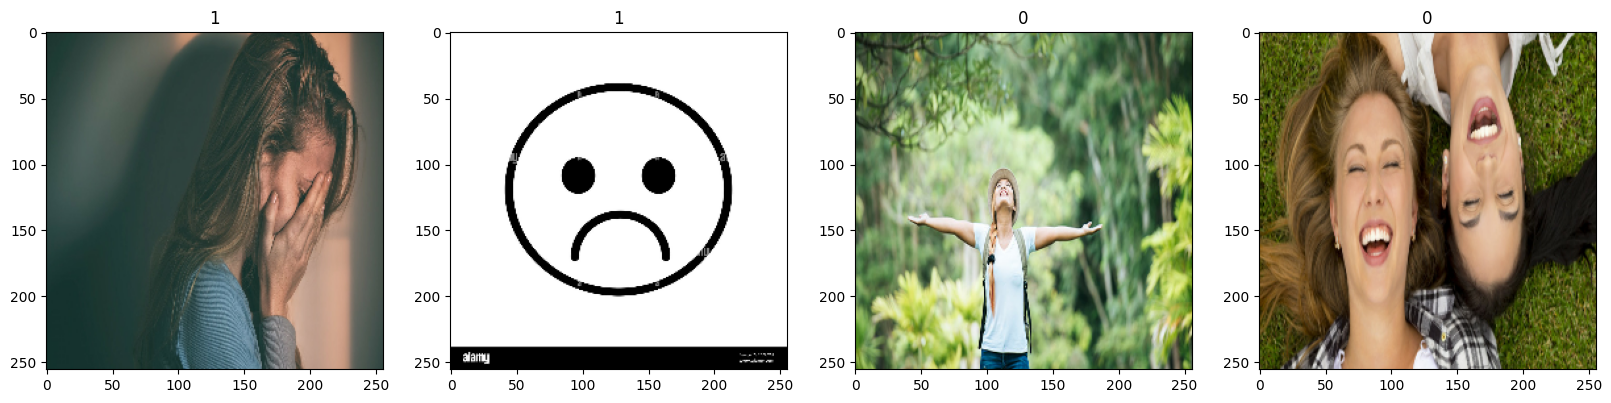

In [15]:
# Now labels are in form 0 and 1. Let's see what they stand for
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

From above display we came to know that label = 1 is for sad images and 0 is for happy images

## **Preprocess Data**

In [16]:
# Scale data
data = data.map(lambda x,y: (x/255, y))

In [17]:
scaled_iterator = data.as_numpy_iterator() # to convert into a numpy array

In [18]:
batch = scaled_iterator.next()

In [19]:
batch[0].max(), batch[0].min()

(1.0, 0.0)

In [20]:
len(data)

6

***Split Data***

In [21]:
# Decide the no of batches you want in the sets
train_size = int(len(data)*.6)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [22]:
# Distribute the batches of data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [23]:
len(train),len(val),len(test)

(3, 2, 1)

## Build the Deep Learning Model

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [25]:
model = Sequential()

**Conv2D(X, (a,b), d)**

here,


*    **X **is #filters in convolutional layer
*   (a,b) each filter is **a** pixels by **b** pixels (size of filter)

*   move **d** pixels each time (stride)








**MaxPooling2D()**

Takes all the output from the above layers and condenses it.

Takes the maximum value after relu activation and return it.

In [26]:
# Add the Convolutional Layer and Condense its output using MaxPooling2D
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

#Flatten the output from above layers to feed into the Dense layers
model.add(Flatten())
#Add the Dense Layers
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('adam', loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## **Train Model**

In [30]:
logdir = '/content/drive/MyDrive/ImageClassification/logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 19s 5s/step - loss: 1.3354 - accuracy: 0.4792 - val_loss: 1.1955 - val_accuracy: 0.4844
Epoch 2/20
3/3 [==============================] - 15s 4s/step - loss: 1.0352 - accuracy: 0.4583 - val_loss: 0.6378 - val_accuracy: 0.6406
Epoch 3/20
3/3 [==============================] - 15s 4s/step - loss: 0.7452 - accuracy: 0.5729 - val_loss: 0.7939 - val_accuracy: 0.5156
Epoch 4/20
3/3 [==============================] - 15s 5s/step - loss: 0.5840 - accuracy: 0.6667 - val_loss: 0.6030 - val_accuracy: 0.6875
Epoch 5/20
3/3 [==============================] - 15s 4s/step - loss: 0.6072 - accuracy: 0.7500 - val_loss: 0.6294 - val_accuracy: 0.7344
Epoch 6/20
3/3 [==============================] - 15s 4s/step - loss: 0.6010 - accuracy: 0.7812 - val_loss: 0.5066 - val_accuracy: 0.8594
Epoch 7/20
3/3 [==============================] - 20s 8s/step - loss: 0.5172 - accuracy: 0.7604 - val_loss: 0.4970 - val_accuracy: 0.7656
Epoch 8/20
3/3 [==================

In [34]:
#hist.history

## **Plot Performance**

**Loss Graph**

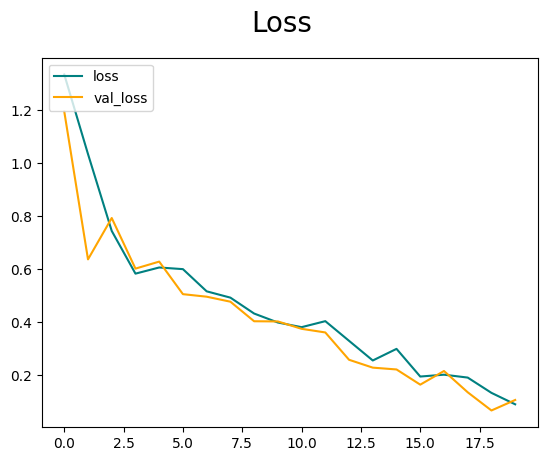

In [35]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

**Accuracy Graph**

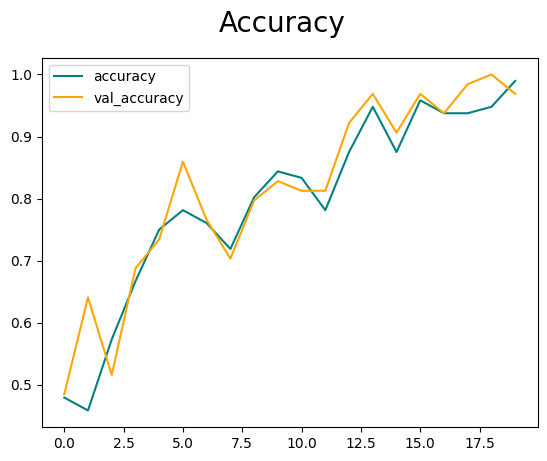

In [36]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate Performance

In [37]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [38]:
pre = Precision()
rec = Recall()
bin_acc = BinaryAccuracy()

In [39]:
# loop through each batch in the test set. Check prediction and actual
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  rec.update_state(y, yhat)
  bin_acc.update_state(y, yhat)

1/1 [==============================] - 1s 895ms/step


In [40]:
print(f"Precision: {pre.result()}, Recall: {rec.result()}, Binary Accuracy: {bin_acc.result()}")

Precision: 1.0, Recall: 1.0, Binary Accuracy: 1.0


**Test**

load image

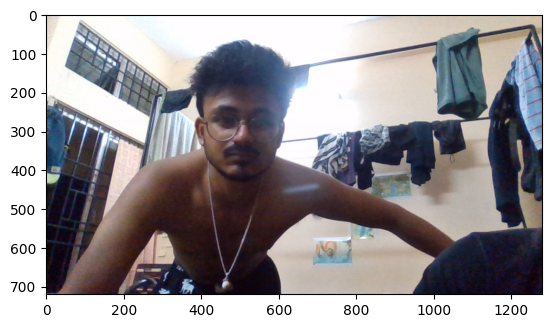

In [41]:
img = cv2.imread('/content/drive/MyDrive/ImageClassification/pic2.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

resize the image

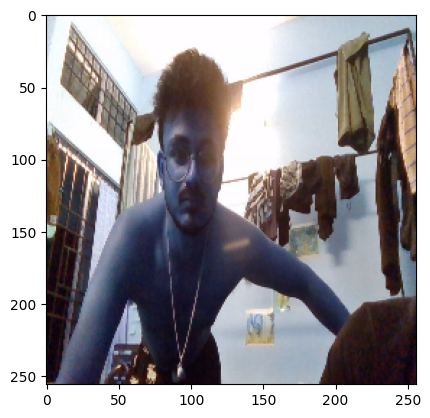

In [42]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

predict the class of image

In [43]:
# our CNN --> used to take images in batches. So to transform this image
# we use np.expand_dims(image, 0)
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 67ms/step


## **Threshold** **Check**

In [44]:
def pred(yhat):
  if yhat > 0.5:
    print('Predicted Class is Sad')
  else:
    print('Predicted Class is Happy')

In [45]:
# Output
pred(yhat)

Predicted Class is Sad


## Save the Model



In [46]:
from keras.models import load_model

In [47]:
model.save(os.path.join('/content/drive/MyDrive/ImageClassification/models', 'happysadmodel.h5'))

## **Load Model and Run**

In [48]:
# load the model
new_model = load_model(os.path.join('/content/drive/MyDrive/ImageClassification/models', 'happysadmodel.h5'))

In [49]:
# load image and resize
photo = cv2.imread('/content/drive/MyDrive/ImageClassification/pic.jpg')
resized_image = tf.image.resize(photo, (256,256))

In [50]:
#predict
photoYhat = new_model.predict(np.expand_dims(resized_image/255, 0))

1/1 [==============================] - 0s 112ms/step


In [51]:
#output
pred(photoYhat)

Predicted Class is Happy
